### A/B testing tutorial:
A/B testing tutorial In this tutorial includes: Introduction to A/B testing How to deploy A/B testing step by step in Python 

Problem: Bạn thiết kế website bán hàng cho một doanh nghiệp thương mại điện tử. Để nâng cao tỷ lệ chuyển đổi, bạn thiết kế phiên bản mới cho các trang sản phẩm. Quân lý bán hàng cho bạn biết tỷ lệ chuyển đổi hiện tại khoảng 13%, và sẽ hài lòng nếu tăng thêm 2%, có nghĩa là thiết kế mới sẽ được xem là thành công nếu nó nâng tỷ lệ chuyển đổi lên 15%.


In [3]:
# Packages imports 
import numpy as np 
import pandas as pd 
import scipy.stats as stats 
import statsmodels.stats.api as sms #package thống kê
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
from math import ceil 
import os
#os.chdir('D:/Python_Pro')

Với ngữ cảnh: tỷ lệ chuyển đổi là 13%, lên 2% là 15%. Tính kích thước mẫu tối thiểu cho mỗi nhóm: required_n

In [4]:
#Choosing a sample size. How many people should we have in each group? 
effect_size = sms.proportion_effectsize(0.13, 0.15) #Calculating effect size 

required_n = sms.NormalIndPower().solve_power( 
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1 
)                                               #Calculating sample size 

required_n = ceil(required_n)                    #Rounding up to next who 

print(required_n)

4720


In [5]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
Nhóm control cho xem old_page, Nhóm treatment cho xem new_page
0: Không mua hàng, 1: mua hàng => Tỷ lệ chuyển đổi thành công

SyntaxError: invalid syntax (1176333422.py, line 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id - The user ID of each session 
timestamp - Timestamp for the session 
group Which group the user was assigned to for that session (control, treatment} 
landing_page -  Which design each user saw on that session (old_page, new_page} 
converted - Whether the session ended in a conversion or not (binary, e=not converted, 1-converted) 
converted: 
0 - The user did not buy the product during this user session 
1 - The user bought the product during this user session

### Ta đánh giá xem new_page có tốt hơn old_page hay không?

In [8]:
# Cross-tabutation 
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [9]:
#number of unique values
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [10]:
session_counts=df['user_id'].value_counts(ascending=False) 
multi_users = session_counts[session_counts > 1].count() 
print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


And 3894  = 294478 - 290584

In [11]:
# remove users with a session count greater than 1 from the df 
users_to_drop = session_counts [session_counts > 1].index 
df = df[~df['user_id'].isin(users_to_drop)] 
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


And 286690   = 290584 - 3894

In [12]:
#sample n=4720 entries for each of the groups 
control_sample=df[df['group']=='control'].sample(n=required_n, random_state= 22)
treatment_sample= df[df['group']=='treatment'].sample(n=required_n, random_state = 22) 

ab_test = pd.concat([control_sample, treatment_sample], axis = 0) 
ab_test.reset_index(drop=True, inplace=True)

In [13]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [14]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [15]:
ab_test['group'].value_counts()

group
control      4720
treatment    4720
Name: count, dtype: int64

In [16]:
conversion_rates = ab_test.groupby('group') ['converted' ] 

#Std. deviation of the proportion 
#Std. error of the proportion (std / sqrt (n) ) 

std_p = lambda x: np.std(x, ddof=0) 
se_p = lambda x: stats.sem(x, ddof=0) 

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation','std_error']

conversion_rates.style.format ('{:.3f}')
#Biểu diễn tỷ lệ chuyển đổi, độ lệch chuẩn, sai số chuẩn

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


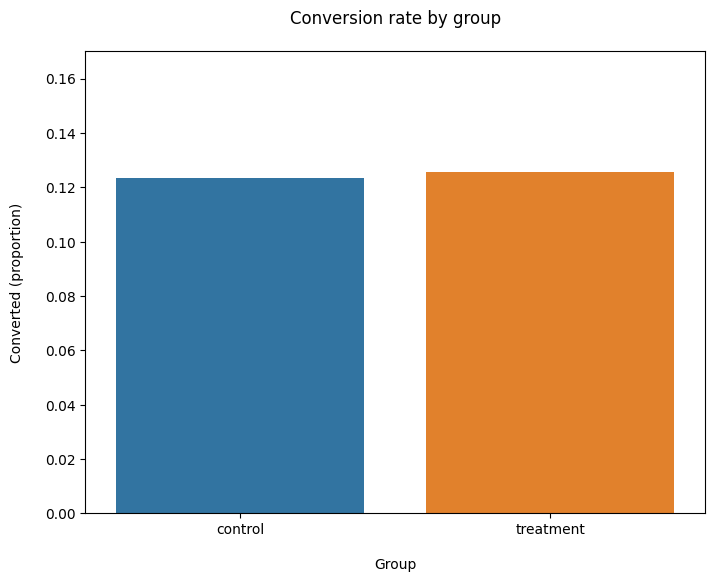

In [17]:
plt.figure(figsize=(8,6)) 
sns.barplot(x=ab_test['group'], y=ab_test['converted'], errorbar=('ci', False)) 
plt.ylim(0, 0.17) 
plt.title('Conversion rate by group', pad=20) 
plt.xlabel('Group', labelpad=15) 
plt.ylabel('Converted (proportion)', labelpad=15);

Vấn đề đặt ra hiện tại là có sự khác biệt nào đáng kể giữa `control` và `treatment` hay không?


Testing the hypothesis: z-test, two-tailed test (do có std_deviation nên dùng z-test)
significance level (alpha): 5%, confidence level: 95% 
p,p0 stand for conversion rate of the new and old design, respectively. 
H0: p=p0 
H1: p<>pe

In [18]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint 

In [19]:
control_results= ab_test[ab_test['group'] == 'control']['converted'] 
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
control_results

0       0
1       0
2       0
3       0
4       0
       ..
4715    0
4716    0
4717    0
4718    0
4719    0
Name: converted, Length: 4720, dtype: int64

In [ ]:
Key point: Mấu chốt vấn đề: 
successes= [control_results.sum(), treatment_results.sum()] 
z_stat, pval = proportions_ztest(successes, nobs=nobs) 

Dùng ztest one-sample để AB test:
Một thử nghiệm Z tỷ lệ : One Proportion Z test, được sử dụng để so sánh tỷ lệ quan sát được với tỷ lệ lý thuyết.
z statistic/ z score là giá trị tra bảng theo công thức: z-score = (x – μ) /  σ
Link: https://www.statology.org/z-table/
Link: https://www.statology.org/how-to-use-z-table/

In [ ]:
Nguyên lý One Proportion Z test:
Count: The number of successes
Nobs: Số lượng thử nghiệmThe number of trials
value: Tỷ lệ dân số được đưa ra giả thuyếtThe hypothesized population proportion
#proportions_ztest(count=60, nobs=100, value=0.64)

In [20]:
n_con= control_results.count() 
n_treat= treatment_results.count() 
successes= [control_results.sum(), treatment_results.sum()] 
nobs= [n_con, n_treat]

In [21]:
successes

[582, 593]

In [27]:
nobs

[4720, 4720]

In [28]:
z_stat, pval = proportions_ztest(successes, nobs=nobs) 
z_stat, pval

(-0.342955932739339, 0.7316316123467367)

In [29]:
n_con= control_results.count() 
n_treat= treatment_results.count() 
successes= [control_results.sum(), treatment_results.sum()] 
nobs= [n_con, n_treat] 

z_stat, pval = proportions_ztest(successes, nobs=nobs) 
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha =0.05)

print (f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}') 
print(f'ci 95% for control group: [{lower_con: .3f}, {upper_con:.3f}]') 
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [ 0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


ci: Confidence Intervals khoảng tin cậy, được thực hiện dựa trên giả thiết rằng dữ liệu được quan sát là các mẫu ngẫu nhiên từ một quần thể đích. Do vậy khoảng tin cậy nhận được từ việc tính toán dữ liệu, cũng là con số mang tính ngẫu nhiên. 

Confidence level: Độ tin cậy là con số ước lượng nhất định, được đưa ra trước khi tiến hành khảo sát dữ liệu (vd: 90%, 95%, 99% )



p-value= 0.732 > alpha =0.05 chúng ta không có cơ sở bác bỏ giả thuyết H0. Tức là tỷ lệ chuyển đổi của thiết kế mới không có khác biệt đáng kể so với thiết kế cũ. 

Ngoài ra, khoảng tin cậy 95% cho nhóm treatment ([0,116, 0,135), tức là [11,6%-13,5%]):

Bao gồm giá trị tỷ lệ chuyển đổi ban đầu là 13% 
Không bao gồm giá trị mục tiêu là 15% 
Điều này có nghĩa là khả năng cao tỷ lệ chuyển đổi thực sự của thiết kế mới tương tự như tỷ lệ chuyển đổi của phiên bản cũ, chứ không phải đạt 15% như mục tiêu đặt ra. Điều này là bằng chứng khác cho thấy thiết kế mới của chúng ta không có khả năng cải thiện so với thiết kế cũ.